## Notebook Imports

In [1]:
from os import walk
from os.path import join

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image

from sklearn.model_selection import train_test_split

%matplotlib inline

## Constants

In [2]:
EXAMPLE_FILE = 'SpamData/01_Processing/practice_email.txt'

SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

DATA_JSON_FILE = 'SpamData/01_Processing/email-text-data.json'
WORD_ID_FILE = 'SpamData/01_Processing/word-by-id.csv'

TRAINING_DATA_FILE = 'SpamData/02_Training/train-data.txt'
TEST_DATA_FILE = 'SpamData/02_Training/test-data.txt'

THUMBS_UP_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-down.png'
CUSTOM_FONT_FILE = 'SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf'

## Reading Files

In [3]:
stream = open(EXAMPLE_FILE, encoding='latin-1')
message = stream.read()
stream.close()

print(type(message))
print(message)

<class 'str'>
From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: fro

In [4]:
stream = open(EXAMPLE_FILE, encoding='latin-1')

is_body = False
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body = True
        
stream.close()
email_body = '\n'.join(lines)
print(email_body)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

## Email body extraction

In [5]:
def email_body_generator(path):
    
    for root,dirnames, filenames in walk(path):
        for file_name in filenames:
            
            filepath = join(root,file_name)
            stream = open(filepath, encoding='latin-1')
            
            is_body = False
            lines = []
            
            for line in stream:
                if is_body:
                    lines.append(line)
                elif line =='\n':
                    is_body = True
                    
            stream.close()
            email_body = '\n'.join(lines)
            yield file_name, email_body

In [6]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE' : email_body, 'CATEGORY': classification})
        row_names.append(file_name)
        
    return pd.DataFrame(rows, index=row_names)

In [7]:
spam_emails = df_from_directory(SPAM_1_PATH,SPAM_CAT)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH,SPAM_CAT))
spam_emails.head()

,CATEGORY,MESSAGE
00234.6b386bd178f4ae52c67b6c6d15ece489,1,REQUEST FOR URGENT BUSINESS ASSISTANCE\n\n---...
00150.f97c73fa56460a6afc6d9418ad76b5b5,1,This is a multi-part message in MIME format.\n...
00282.0e230e05877f40a522bfb93aa3e314f3,1,<html>\n\n<head>\n\n</head>\n\n<center>\n\n<h1...
00457.f8db516c753eff2c82cfb89b33bd2620,1,<HTML>\n\n<HEAD>\n\n</HEAD>\n\n<BODY>\n\nVIAGR...
00368.2c1ab4bc7f408e0fcb22dca9b2d5a113,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 3.2//E..."


In [8]:
spam_emails.shape

(1898, 2)

In [9]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH,HAM_CAT))
ham_emails.shape

(3901, 2)

In [10]:
data = pd.concat([spam_emails, ham_emails])
print('Shape of entire dataframe is ', data.shape)
data.head()

Shape of entire dataframe is  (5799, 2)


,CATEGORY,MESSAGE
00234.6b386bd178f4ae52c67b6c6d15ece489,1,REQUEST FOR URGENT BUSINESS ASSISTANCE\n\n---...
00150.f97c73fa56460a6afc6d9418ad76b5b5,1,This is a multi-part message in MIME format.\n...
00282.0e230e05877f40a522bfb93aa3e314f3,1,<html>\n\n<head>\n\n</head>\n\n<center>\n\n<h1...
00457.f8db516c753eff2c82cfb89b33bd2620,1,<HTML>\n\n<HEAD>\n\n</HEAD>\n\n<BODY>\n\nVIAGR...
00368.2c1ab4bc7f408e0fcb22dca9b2d5a113,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 3.2//E..."


In [11]:
data.tail()

,CATEGORY,MESSAGE
00154.7bda4738681c601e0fd93f3c6d1ae4a1,0,"On Tue, Jul 30, 2002 at 11:28:11AM +0200, Davi..."
00363.2c66a99268facef9c5dab8c1f7b81190,0,"Paul, my apologies for being irritable on the ..."
00449.9272eb34ed6d02f46e34bd7300d9e7d8,0,Yes indeed - there should be an agents directo...
00062.43847c613a539ca9c47b4593ee34bd6d,0,There's been some discussion just now on the I...
00912.74b435accaf4e65a948c7769b6380f01,0,"On Fri, 2002-07-26 at 12:49, Ian Andrew Bell w..."


## Data Cleaning: Checking for Missing Values

In [12]:
data['MESSAGE'].isnull().values.any()

False

In [13]:
(data.MESSAGE.str.len()==0).sum()

3

## Locate empty emails

In [14]:
data[data.MESSAGE.str.len()==0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [15]:
data.drop(['cmds'], inplace=True)

In [16]:
data.shape

(5796, 2)

## Add Document IDs to Track Emails in Dataset

In [17]:
document_ids = range(0, len(data.index))
data['DOC_ID'] = document_ids

In [18]:
data['FILE_NAME'] = data.index
data.set_index('DOC_ID', inplace=True)
data.head()

,CATEGORY,MESSAGE,FILE_NAME
DOC_ID,,,
0,1,REQUEST FOR URGENT BUSINESS ASSISTANCE\n\n---...,00234.6b386bd178f4ae52c67b6c6d15ece489
1,1,This is a multi-part message in MIME format.\n...,00150.f97c73fa56460a6afc6d9418ad76b5b5
2,1,<html>\n\n<head>\n\n</head>\n\n<center>\n\n<h1...,00282.0e230e05877f40a522bfb93aa3e314f3
3,1,<HTML>\n\n<HEAD>\n\n</HEAD>\n\n<BODY>\n\nVIAGR...,00457.f8db516c753eff2c82cfb89b33bd2620
4,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 3.2//E...",00368.2c1ab4bc7f408e0fcb22dca9b2d5a113


In [19]:
data.to_json(DATA_JSON_FILE)

## Number of Spam and Ham messages Visualised

In [20]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [21]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

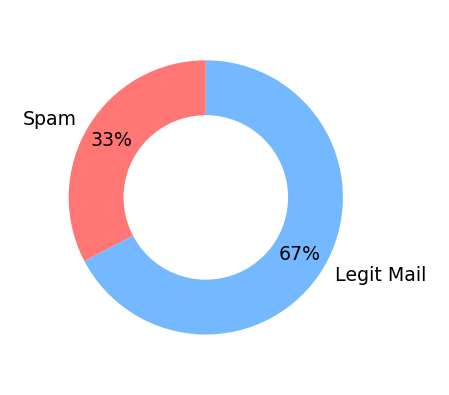

In [22]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colours = ['#ff7675','#74b9ff']

plt.figure(figsize=(2,2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize':6}, startangle=90,
       autopct='%1.0f%%', colors=custom_colours, pctdistance=0.8)

centre_circle = plt.Circle((0,0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

## Download NLP Packages

In [23]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/anish/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [24]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/anish/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Functions for Email Processing

In [25]:
def clean_message(message, stemmer=PorterStemmer(), stop_words=set(stopwords.words('english'))):
    words = word_tokenize(message.lower())
    
    filtered_words = []
    
    for word in words:
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
            
    return filtered_words

In [26]:
clean_message(email_body)

['dear',
 'mr',
 'still',
 'good',
 'tide',
 'staff',
 'festiv',
 'season',
 'ahead',
 'christma',
 'crux',
 'fulli',
 'qualifi',
 'santa',
 'clau',
 'wonder',
 'whether',
 'might',
 'consid',
 'run',
 'santa',
 'grotto',
 'store',
 'wait',
 'probabl',
 'think',
 'make',
 'special',
 'well',
 'first',
 'made',
 'sever',
 'chang',
 'characteris',
 'father',
 'christma',
 'rather',
 'greet',
 'children',
 'shout',
 'ho',
 'ho',
 'ho',
 'prefer',
 'whisper',
 'phrase',
 'depend',
 'unfathom',
 'cruel',
 'world',
 'live',
 'addit',
 'gift',
 'rang',
 'felt',
 'hoop',
 'holder',
 'note',
 'also',
 'enclos',
 'sketch',
 'radic',
 'redesign',
 'santa',
 'outfit',
 'renam',
 'charact',
 'lord',
 'buckl',
 'would',
 'interest',
 'employ',
 'promis',
 'never',
 'let',
 'look',
 'forward',
 'hear',
 'best',
 'wish',
 'robin',
 'cooper',
 'excerpt',
 'book',
 'timewast',
 'letter',
 'robin',
 'cooper']

In [27]:
def clean_msg_no_html(message, stemmer = PorterStemmer(), stop_words=set(stopwords.words('english'))):
    soup = BeautifulSoup(message, 'html.parser')
    cleaned_text = soup.get_text()
    
    words = word_tokenize(cleaned_text.lower())
    
    filtered_words = []
    
    for word in words:
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
            
    return filtered_words

In [28]:
clean_msg_no_html(data.at[2,'MESSAGE'])

['free',
 'person',
 'busi',
 'grant',
 'qualifi',
 'least',
 'free',
 'grant',
 'money',
 'guarante',
 'day',
 'one',
 'million',
 'dollar',
 'free',
 'govern',
 'grant',
 'given',
 'away',
 'peopl',
 'like',
 'wide',
 'varieti',
 'busi',
 'person',
 'need',
 'dear',
 'grant',
 'seeker',
 'moment',
 'tell',
 'exactli',
 'get',
 'grant',
 'money',
 'given',
 'away',
 'may',
 'think',
 'get',
 'free',
 'grant',
 'money',
 'mayb',
 'think',
 'imposs',
 'get',
 'free',
 'money',
 'let',
 'tell',
 'imposs',
 'fact',
 'ordinari',
 'peopl',
 'busi',
 'across',
 'unit',
 'state',
 'receiv',
 'million',
 'dollar',
 'govern',
 'privat',
 'foundat',
 'everyday',
 'appli',
 'anyon',
 'appli',
 'grant',
 'year',
 'old',
 'grant',
 'possibl',
 'grant',
 'paid',
 'back',
 'ever',
 'claim',
 'slice',
 'free',
 'american',
 'pie',
 'money',
 'loan',
 'tri',
 'get',
 'money',
 'convent',
 'bank',
 'time',
 'consum',
 'requir',
 'lot',
 'paperwork',
 'find',
 'deni',
 'govern',
 'agenc',
 'oper',
 'stri

In [29]:
%%time

nested_list = data.MESSAGE.apply(clean_msg_no_html)

/home/anish/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:336: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


CPU times: user 35.7 s, sys: 33.6 ms, total: 35.7 s
Wall time: 35.7 s


In [30]:
nested_list.tail()

DOC_ID
5791    [tue, jul, david, neari, mention, exampl, say,...
5792    [paul, apolog, irrit, subject, tone, rhetor, q...
5793    [ye, inde, agent, directori, verita, cd, unix,...
5794    [discuss, ilug, irc, channel, osi, protocol, l...
5795    [fri, ian, andrew, bell, wrote, particularli, ...
Name: MESSAGE, dtype: object

In [31]:
doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham = data[data.CATEGORY == 0].index

In [32]:
doc_ids_ham

Int64Index([1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905,
            ...
            5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5794, 5795],
           dtype='int64', name='DOC_ID', length=3900)

In [33]:
nested_list_ham = nested_list.loc[doc_ids_ham]

In [34]:
nested_list_ham.shape

(3900,)

In [35]:
nested_list_ham.tail()

DOC_ID
5791    [tue, jul, david, neari, mention, exampl, say,...
5792    [paul, apolog, irrit, subject, tone, rhetor, q...
5793    [ye, inde, agent, directori, verita, cd, unix,...
5794    [discuss, ilug, irc, channel, osi, protocol, l...
5795    [fri, ian, andrew, bell, wrote, particularli, ...
Name: MESSAGE, dtype: object

In [36]:
nested_list_spam = nested_list.loc[doc_ids_spam]

In [37]:
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
normal_words = pd.Series(flat_list_ham).value_counts()
normal_words.shape[0]

20755

In [38]:
normal_words[:10]

http      7561
use       3630
list      2878
one       2371
get       2284
mail      2255
would     2003
like      1928
messag    1847
work      1798
dtype: int64

In [39]:
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
spammy_words = pd.Series(flat_list_spam).value_counts()
spammy_words.shape[0]

13284

In [40]:
spammy_words[:10]

http      3101
email     3094
free      2555
click     2058
receiv    1987
list      1974
get       1903
pleas     1842
busi      1792
order     1743
dtype: int64

## Word Cloud

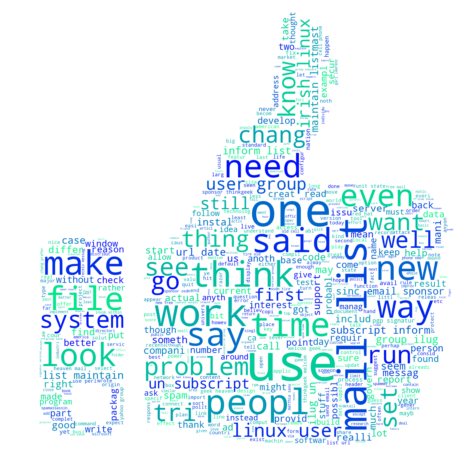

In [41]:
icon = Image.open(THUMBS_UP_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) 

ham_str = ' '.join(flat_list_ham)

word_cloud = WordCloud(mask=rgb_array, background_color='white', 
                      max_words=500, colormap='winter')

word_cloud.generate(ham_str)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

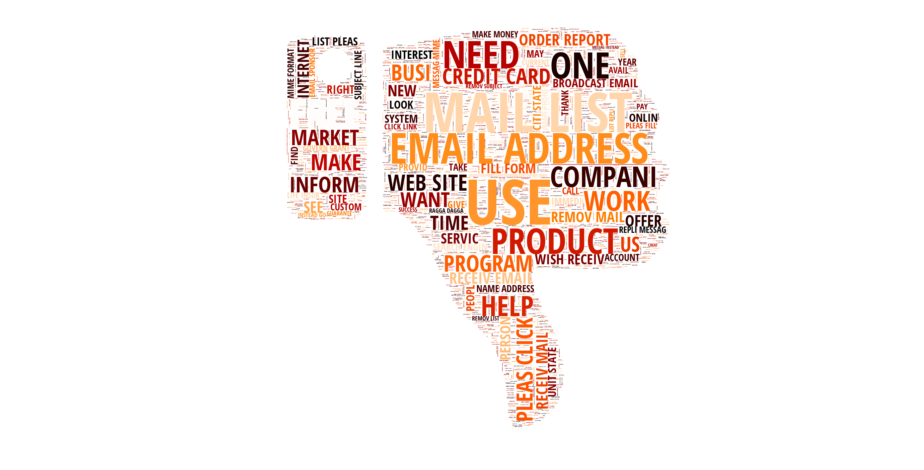

In [42]:
icon = Image.open(THUMBS_DOWN_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) 

spam_str = ' '.join(flat_list_spam)

word_cloud = WordCloud(mask=rgb_array, background_color='white', 
                      max_words=2000, colormap='gist_heat', font_path=CUSTOM_FONT_FILE)
spam_str = spam_str.upper()
word_cloud.generate(spam_str)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Generating Vocabulary & Dictionary

In [43]:
stemmed_nested_list = data.MESSAGE.apply(clean_msg_no_html)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

In [44]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print('Number of unique words', unique_words.shape[0])
unique_words.head()

Number of unique words 27305


http     10662
use       5017
list      4852
email     4370
get       4187
dtype: int64

In [45]:
frequent_words = unique_words[0:VOCAB_SIZE]
print('Most common words: \n', frequent_words[:10])

Most common words: 
 http     10662
use       5017
list      4852
email     4370
get       4187
mail      3985
one       3905
free      3171
time      3090
work      2880
dtype: int64


## Create vocabulary DataFrame with a WORD_ID

In [46]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD' : frequent_words.index.values}, index=word_ids)
vocab.index.name = 'WORD_ID'
vocab.head()

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get


In [47]:
vocab.to_csv(WORD_ID_FILE, index_label=vocab.index.name, header=vocab.VOCAB_WORD.name)

## Email with most number of words

In [48]:
clean_email_lengths = [len(sublist) for sublist in stemmed_nested_list]
print('Number of words in the longest email:', max(clean_email_lengths))

Number of words in the longest email: 7671


## Generate Features and a Sparse Matrix

In [49]:
type(stemmed_nested_list)

pandas.core.series.Series

In [50]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())
word_columns_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,request,urgent,busi,assist,contact,avail,chamber,commerc,given,diplomat,...,None,None,None,None,None,None,None,None,None,None
1,messag,mime,format,maxim,select,want,pay,less,term,insur,...,None,None,None,None,None,None,None,None,None,None
2,free,person,busi,grant,qualifi,least,free,grant,money,guarante,...,None,None,None,None,None,None,None,None,None,None
3,viagra,xenic,vioxx,zyban,propecia,offer,real,viagra,xenic,vioxx,...,None,None,None,None,None,None,None,None,None,None
4,untitl,attent,must,comput,user,packag,deal,norton,systemwork,oftwar,...,None,None,None,None,None,None,None,None,None,None


In [51]:
word_columns_df.shape

(5796, 7671)

## Spilitting the Data into a Training and Testing Dataset

In [52]:
X_train, X_test, y_train,y_test = train_test_split(word_columns_df, data.CATEGORY, test_size=0.3, random_state=42)

In [53]:
X_train.index.name = X_test.index.name = 'DOC_ID'
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4844,hi,look,get,hand,either,doom,ii,pc,unfortun,access,...,None,None,None,None,None,None,None,None,None,None
4727,get,hope,career,move,next,stop,hollywood,rememb,madonna,actress,...,None,None,None,None,None,None,None,None,None,None
5022,server,bug,backup,discoveri,server,fix,cheer,chad,scott,augustu,...,None,None,None,None,None,None,None,None,None,None
3504,permiss,issu,razor,log,file,spamassassin,run,setuid,user,mail,...,None,None,None,None,None,None,None,None,None,None
3921,pgp,sign,messag,vincent,cunniff,wrote,justin,maccarthi,wrote,think,...,None,None,None,None,None,None,None,None,None,None


In [54]:
y_train.head()

DOC_ID
4844    0
4727    0
5022    0
3504    0
3921    0
Name: CATEGORY, dtype: int64

## Create a Sparse Matrix for the training data

In [55]:
word_index = pd.Index(vocab.VOCAB_WORD)
word_index

Index(['http', 'use', 'list', 'email', 'get', 'mail', 'one', 'free', 'time',
       'work',
       ...
       'milter', 'trader', 'council', 'advisor', 'mutual', 'burner', 'maxaman',
       'bullet', 'subsequ', 'decreas'],
      dtype='object', name='VOCAB_WORD', length=2500)

In [56]:
def make_sparse_matrix(df, indexed_words, labels):
    """
    Returns sparse matrix as dataframe.
    
    df: A dataframe with words in the columns with a document id as an index (X_train or X_test)
    indexed_words: index of words ordered by word_id
    labels: category as a series (y_train or y_test)
    """
    
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_cols):
            
            word = df.iat[i,j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                
                item = {'LABEL': category, 'DOC_ID': doc_id,
                       'OCCURENCE' : 1, 'WORD_ID' : word_id}
                
                dict_list.append(item)
                
    return pd.DataFrame(dict_list)

In [57]:
%%time
sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)

CPU times: user 3min 24s, sys: 212 ms, total: 3min 24s
Wall time: 3min 24s


In [58]:
sparse_train_df[:5]

,DOC_ID,LABEL,OCCURENCE,WORD_ID
0,4844,0,1,531
1,4844,0,1,40
2,4844,0,1,4
3,4844,0,1,443
4,4844,0,1,431


In [59]:
sparse_train_df.shape

(426844, 4)

### Combining Occurences with the Pandas groupby() Method

In [60]:
train_grouped = sparse_train_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()
train_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
0      0       1              1
       1       1              1
       2       1              1
       6       1              1
       9       1              1

In [61]:
train_grouped = train_grouped.reset_index()
train_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,0,0,1,1
1,0,1,1,1
2,0,2,1,1
3,0,6,1,1
4,0,9,1,1


## Creating Sparse matrix for Test Data

In [62]:
%%time
sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)

CPU times: user 1min 27s, sys: 208 ms, total: 1min 27s
Wall time: 1min 27s


In [63]:
test_grouped = sparse_test_df.groupby(['DOC_ID', 'WORD_ID','LABEL']).sum().reset_index()
test_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,8,0,1,4
1,8,2,1,1
2,8,3,1,1
3,8,5,1,1
4,8,6,1,1


In [64]:
test_grouped.shape

(115650, 4)

In [65]:
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt='%d')
np.savetxt(TEST_DATA_FILE, test_grouped, fmt='%d')